In [2]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
import FinanceDataReader as fdr
tickers = ['AAPL', 'MSFT', 'NFLX', 'AMZN', 'GOOG']
df = pd.DataFrame([fdr.DataReader(ticker, '2002-01-01', '2022-12-01')['Adj Close'] for ticker in tickers]).T
df.columns = tickers
df

,AAPL,MSFT,NFLX,AMZN,GOOG
Date,,,,,
2002-01-02,0.354666,20.965450,NaN,0.548000,NaN
2002-01-03,0.358928,21.650335,NaN,0.595000,NaN
2002-01-04,0.360603,21.547127,NaN,0.612500,NaN
2002-01-07,0.348578,21.440798,NaN,0.617000,NaN
2002-01-08,0.344164,21.697245,NaN,0.592500,NaN
...,...,...,...,...,...
2022-11-23,151.070007,247.580002,291.500000,94.129997,98.820000
2022-11-25,148.110001,247.490005,285.540009,93.410004,97.599998
2022-11-28,144.220001,241.759995,281.170013,93.949997,96.250000


In [13]:

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2018, 12, 31)
df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

TypeError: string indices must be integers

In [16]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 20
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(20)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

In [ ]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 20
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(20)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

In [17]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

In [24]:
results_frame.sort_values("ret")

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG
88520,0.014591,0.074721,0.195273,0.006583,0.822235,0.038342,0.008868,0.123972
27454,0.015163,0.073096,0.207440,0.014443,0.731099,0.023570,0.020060,0.210828
24387,0.015241,0.073032,0.208690,0.007224,0.727097,0.035374,0.009677,0.220627
60571,0.015251,0.075159,0.202912,0.031465,0.790130,0.009687,0.108943,0.059775
8214,0.015529,0.072750,0.213457,0.062748,0.722944,0.027297,0.000688,0.186324
...,...,...,...,...,...,...,...,...
73956,0.032500,0.134304,0.241989,0.066948,0.015785,0.782243,0.112318,0.022706
73632,0.032735,0.136138,0.240456,0.152092,0.029835,0.809374,0.000579,0.008120
62663,0.032904,0.139793,0.235376,0.014428,0.000408,0.822392,0.129741,0.033031
59247,0.033028,0.143680,0.229870,0.035053,0.023443,0.863737,0.056200,0.021567


In [21]:
mean_returns

AAPL    0.001384
MSFT    0.000632
NFLX    0.001728
AMZN    0.001319
GOOG    0.000991
dtype: float64

In [22]:
cov

,AAPL,MSFT,NFLX,AMZN,GOOG
AAPL,0.000474,0.000201,0.000211,0.000240,0.000212
MSFT,0.000201,0.000315,0.000183,0.000224,0.000188
NFLX,0.000211,0.000183,0.001296,0.000326,0.000191
AMZN,0.000240,0.000224,0.000326,0.000680,0.000240
GOOG,0.000212,0.000188,0.000191,0.000240,0.000375


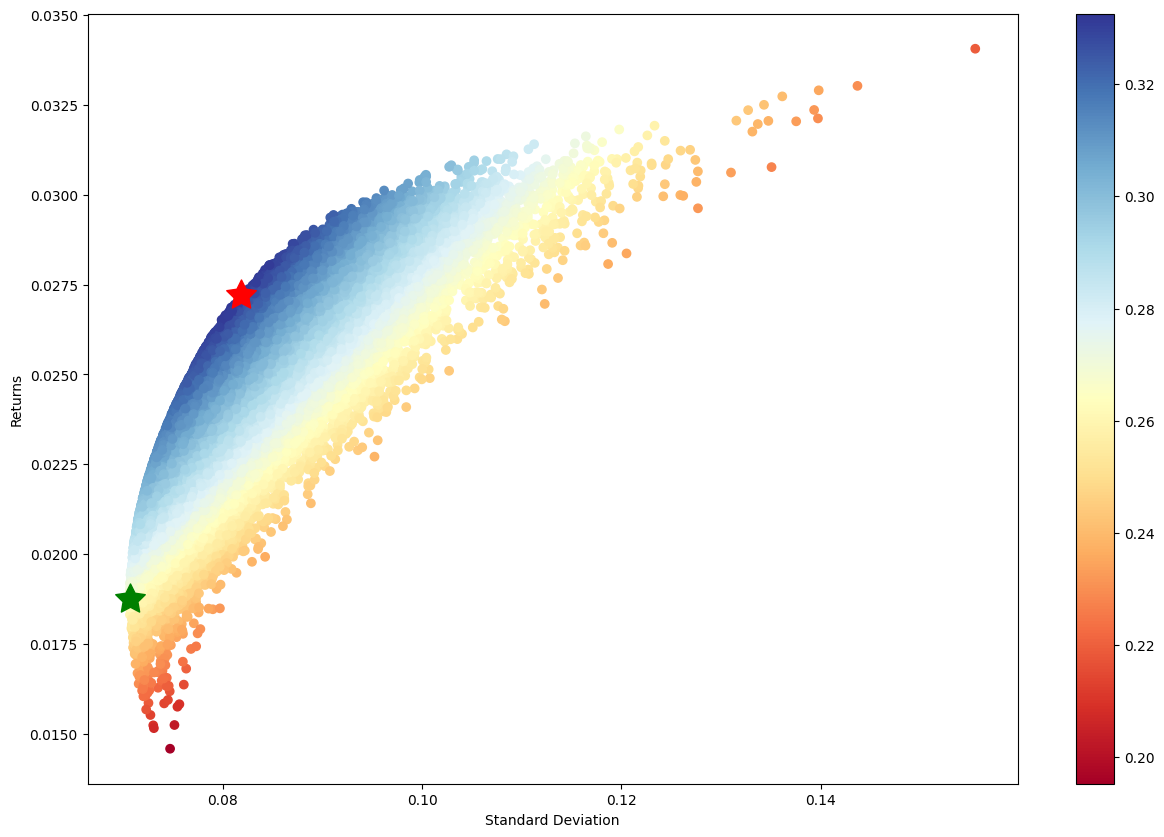

In [18]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()

In [19]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG
70630,0.027206,0.081802,0.332584,0.48175,0.000724,0.162259,0.18514,0.170126


In [20]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG
48131,0.018768,0.070679,0.265533,0.154347,0.464335,0.052894,0.044047,0.284377


In [ ]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

: 

In [9]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.35,0.15,0.23,0.27,0.0


In [10]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std
def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_variance = min_variance(mean_returns, cov)

In [11]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.28,0.4,0.02,0.03,0.27


In [12]:
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df

In [13]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

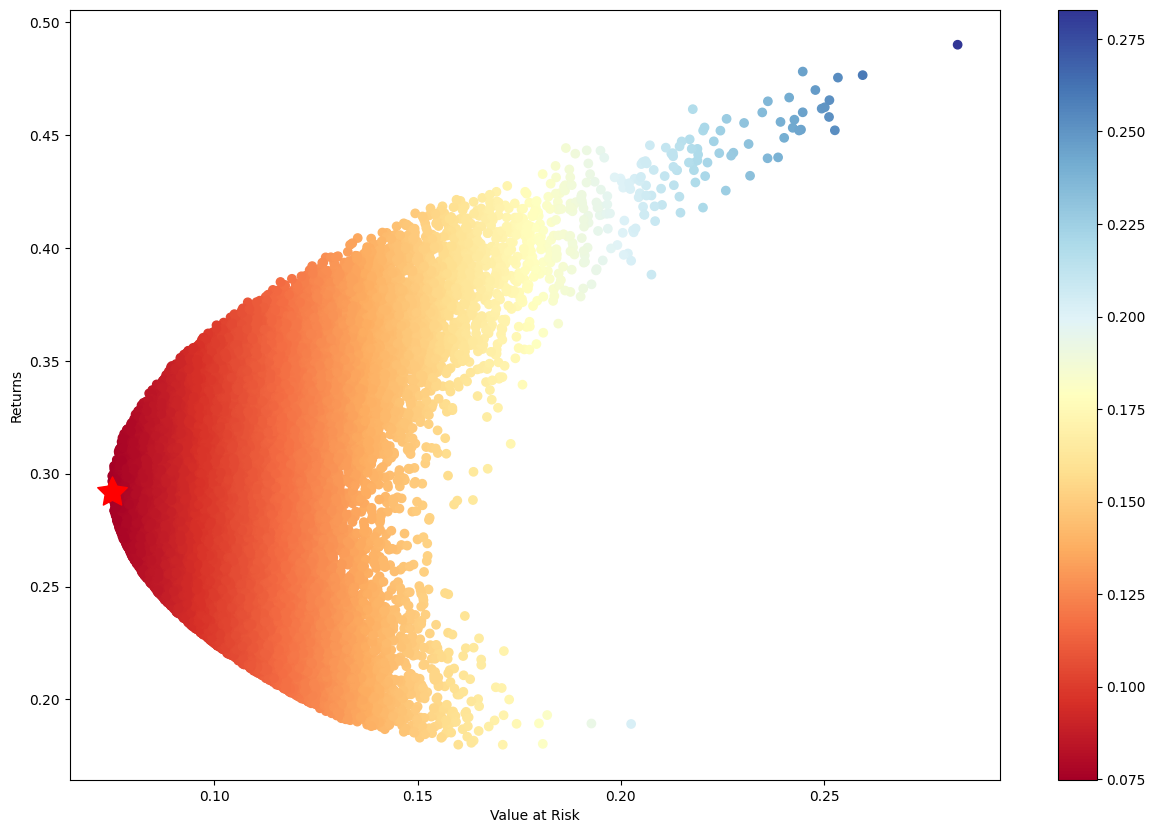

In [14]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [15]:
min_VaR_port.to_frame().T

,ret,stdev,VaR,AAPL,MSFT,NFLX,AMZN,GOOG
77165,0.292009,0.223049,0.074874,0.357262,0.234101,0.174787,0.219499,0.014351


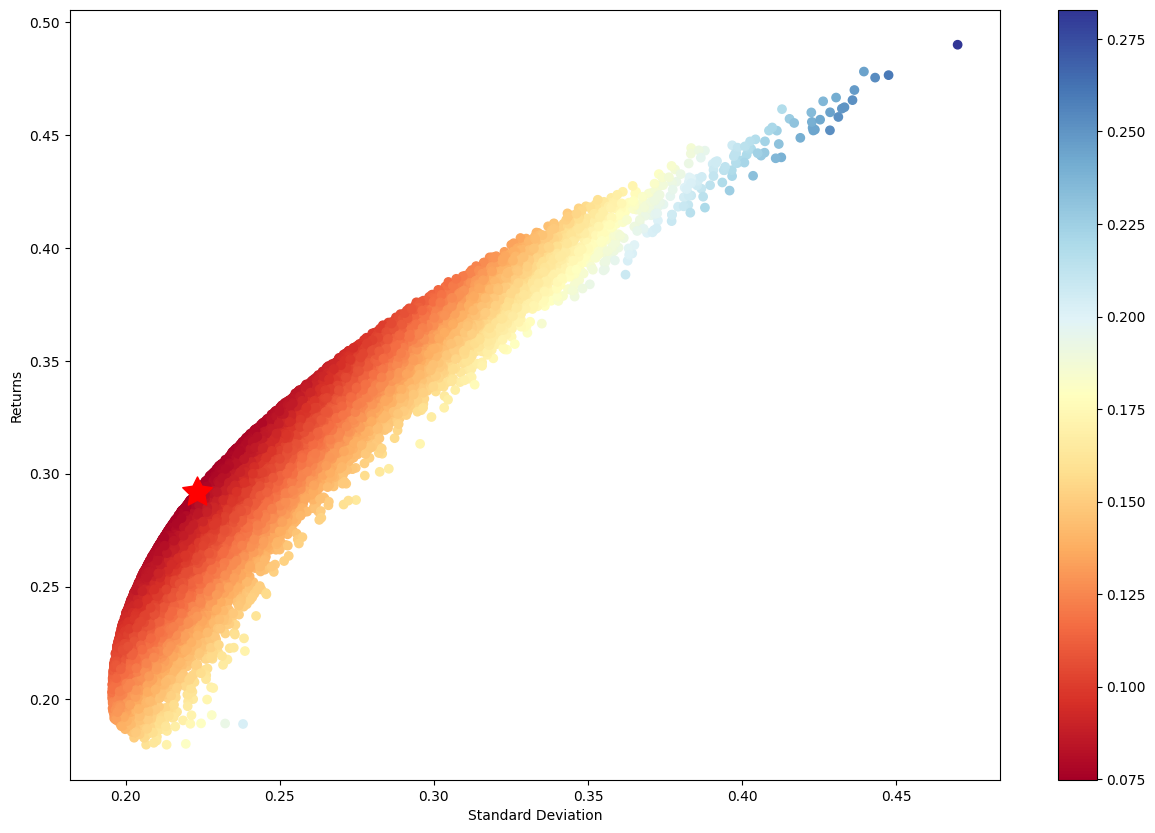

In [16]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [17]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var
def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

In [18]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.35,0.24,0.18,0.23,0.0
